## Step 1: Prepare for the Food Reviews Dataset

In [1]:
# import pandas as pd

# food_reviews_full = pd.read_csv('./food_reviews.csv')

# # Sample the Subset
# subset_size = 2000  # Define the size of your subset
# food_reviews_subset = food_reviews_full.sample(n=subset_size, random_state=42)

# # Save the Subset
# food_reviews_subset.to_csv('food_reviews_subset.csv', index=False)

In [2]:
# food_reviews_subset.head()

In [3]:
import pandas as pd

food_reviews_subset = pd.read_csv('./food_reviews_subset.csv')
# Pre-processing Steps
# Handle Missing Values: Depending on your dataset,
# handle missing values in the 'review' or 'rating' columns.
# For simplicity, we can drop rows with missing values.
food_reviews_subset.dropna(inplace=True)

In [4]:
food_reviews_subset.head()

,Score,Summary,Text
0,1,Misleading Image of Item,Be aware that the image shown is not the true ...
1,5,Delicious,"I love these chips, I buy the 24 pack once a m..."
2,5,Delicious!,This is the best chai I've ever had in my life...
3,3,Bought on Recommendation,I bought this Organic catnip because it came u...
4,5,These chips are addictive!,"<a href=""http://www.amazon.com/gp/product/B000..."


In [5]:
import re
# remove urls and html tags
def remove_links_and_html_tags(text):
    # Remove links
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    return text

# Apply the cleaning function to both 'Summary' and 'Text' columns
food_reviews_subset['Summary'] = food_reviews_subset['Summary'].apply(remove_links_and_html_tags)
food_reviews_subset['Text'] = food_reviews_subset['Text'].apply(remove_links_and_html_tags)

# Display the cleaned data to verify the changes
food_reviews_subset[['Summary', 'Text']].head()


,Summary,Text
0,Misleading Image of Item,Be aware that the image shown is not the true ...
1,Delicious,"I love these chips, I buy the 24 pack once a m..."
2,Delicious!,This is the best chai I've ever had in my life...
3,Bought on Recommendation,I bought this Organic catnip because it came u...
4,These chips are addictive!,I first tasted these chips while visiting re...


In [6]:
import nltk
# Tokenization
from nltk.tokenize import word_tokenize

# Download the punkt tokenizer models
nltk.download('punkt')

# Tokenize the 'Summary' and 'Text' columns
food_reviews_subset['Summary'] = food_reviews_subset['Summary'].apply(
    word_tokenize)
food_reviews_subset['Text'] = food_reviews_subset['Text'].apply(word_tokenize)

# Display the tokenized data
food_reviews_subset[['Summary', 'Text']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zehao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Summary,Text
0,"[Misleading, Image, of, Item]","[Be, aware, that, the, image, shown, is, not, ..."
1,[Delicious],"[I, love, these, chips, ,, I, buy, the, 24, pa..."
2,"[Delicious, !]","[This, is, the, best, chai, I, 've, ever, had,..."
3,"[Bought, on, Recommendation]","[I, bought, this, Organic, catnip, because, it..."
4,"[These, chips, are, addictive, !]","[I, first, tasted, these, chips, while, visiti..."


In [7]:
# combine the summary and text columns
food_reviews_subset['Combination'] = food_reviews_subset['Summary'] + \
    food_reviews_subset['Text']

# remove Summary and Text columns
food_reviews_subset.drop(columns=['Summary', 'Text'], inplace=True)

In [8]:
# remove punctuation
# from string import punctuation
def remove_punctuation(tokens):
    # This part of the list comprehension filters out any tokens
    # that do not satisfy the word.isalnum() condition, meaning any
    # token that is not purely alphanumeric gets removed.
    return [word for word in tokens if word.isalnum()]


# Apply the remove_punctuation function to both 'Summary' and 'Text' columns
food_reviews_subset['Combination'] = food_reviews_subset['Combination'].apply(
    remove_punctuation)

# Display the data to verify the changes
food_reviews_subset[['Combination']].head()

,Combination
0,"[Misleading, Image, of, Item, Be, aware, that,..."
1,"[Delicious, I, love, these, chips, I, buy, the..."
2,"[Delicious, This, is, the, best, chai, I, ever..."
3,"[Bought, on, Recommendation, I, bought, this, ..."
4,"[These, chips, are, addictive, I, first, taste..."


In [9]:
# lower case
def to_lowercase(tokens):
    return [word.lower() for word in tokens]

# Apply the to_lowercase function to the 'Combination' column
food_reviews_subset['Combination'] = food_reviews_subset['Combination'].apply(
    to_lowercase)

food_reviews_subset[['Combination']].head()

,Combination
0,"[misleading, image, of, item, be, aware, that,..."
1,"[delicious, i, love, these, chips, i, buy, the..."
2,"[delicious, this, is, the, best, chai, i, ever..."
3,"[bought, on, recommendation, i, bought, this, ..."
4,"[these, chips, are, addictive, i, first, taste..."


In [10]:
# remove stop words
from nltk.corpus import stopwords
nltk.download('stopwords')

# Get the English stop words
stop_words = set(stopwords.words('english'))


def remove_stop_words(tokens):
    return [word for word in tokens if word.lower() not in stop_words]


# Apply the remove_stop_words function to the 'Combination' column
food_reviews_subset['Combination_without_stopwords'] = food_reviews_subset['Combination'].apply(
    remove_stop_words)

# Display the data to verify the changes
food_reviews_subset['Combination_without_stopwords'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zehao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [misleading, image, item, aware, image, shown,...
1    [delicious, love, chips, buy, 24, pack, month,...
2    [delicious, best, chai, ever, life, well, exce...
3    [bought, recommendation, bought, organic, catn...
4    [chips, addictive, first, tasted, chips, visit...
Name: Combination_without_stopwords, dtype: object

In [11]:
# stemming and lemmatization with Part of Speech (POS) tagging
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize(tokens):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]


# Apply the lemmatize function to the 'Combination_without_stopwords' column
food_reviews_subset['Combination_without_stopwords_Lemmatized'] = food_reviews_subset['Combination_without_stopwords'].apply(
    lemmatize)

# Display the data to verify the changes
food_reviews_subset['Combination_without_stopwords_Lemmatized'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zehao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zehao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


0    [mislead, image, item, aware, image, show, tru...
1    [delicious, love, chip, buy, 24, pack, month, ...
2    [delicious, best, chai, ever, life, well, exce...
3    [bought, recommendation, bought, organic, catn...
4    [chip, addictive, first, taste, chip, visit, r...
Name: Combination_without_stopwords_Lemmatized, dtype: object

In [12]:
food_reviews_subset['Final_review'] = food_reviews_subset['Combination_without_stopwords_Lemmatized']

In [13]:
food_reviews_subset.to_csv('food_reviews_subset_cleanned.csv', index=False)

### Seperate the Training Set and Testing Set

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd
# Load the cleaned dataset
food_reviews = pd.read_csv('./food_reviews_subset_cleanned.csv')

# Split the data into training and testing sets
Review_train, Review_test, Score_train, Score_test = train_test_split(
    food_reviews['Final_review'], food_reviews['Score'], test_size=0.3, random_state=42)

## Step 2: Naive Bayes

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# 2. Create a Pipeline for TF-IDF Vectorization and Naive Bayes Model
nb_pipeline = Pipeline([
    # Text representation: TF-IDF
    ('tfidf', TfidfVectorizer()),
    # Classifier: Multinomial Naive Bayes
    ('naive_bayes', MultinomialNB())
])

# 3. Train the Naive Bayes Model
nb_pipeline.fit(Review_train, Score_train)

# 4. Test the Model
Score_pred = nb_pipeline.predict(Review_test)

# 5. Evaluate the Model
print("Accuracy:", accuracy_score(Score_test, Score_pred))
# print("\nClassification Report:\n", classification_report(Score_test, Score_pred))

Accuracy: 0.6466666666666666


## Step 3 kNN

Best k: 7 with Test Set Accuracy: 0.65


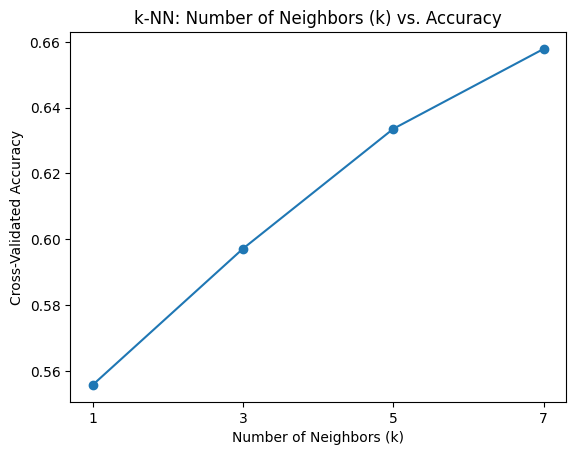

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Assuming 'df_subset' is your cleaned DataFrame containing 'Cleaned_Text' and 'Score' columns
# Step 2: Set up a pipeline with TF-IDF and k-NN
k_values = [1, 3, 5, 7]
cross_val_scores = []

for k in k_values:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])

    # Use cross-validation to evaluate the model
    scores = cross_val_score(pipeline, Review_train, Score_train,
                             cv=5, scoring='accuracy')
    cross_val_scores.append(np.mean(scores))

# Step 3: Find the best k based on cross-validation scores
best_k_index = np.argmax(cross_val_scores)
best_k = k_values[best_k_index]

# Train the final model with the best k
final_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])
final_model.fit(Review_train, Score_train)

# Test the final model on the test set
Score_pred = final_model.predict(Review_test)

# Evaluate the final model
accuracy = accuracy_score(Score_test, Score_pred)
print(f"Best k: {best_k} with Test Set Accuracy: {accuracy}")

# Step 4: Plot k vs. classification performance
plt.plot(k_values, cross_val_scores, marker='o')
plt.title('k-NN: Number of Neighbors (k) vs. Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_values)
plt.show()